# NLP: From Attention-Seq2Seq to Transfermor

The weight $\alpha_{ij}$ shown in the follwoing graph can be obtained by calculating the correlation between $s_j$ and each $h_m$, with the help of the following equation: 
                                            $$\alpha_{ij}=align(h_i, s_j)$$
                                           Key: $$K_{:i}=W_k h_i$$
                                           Query: $$q_{:j}=W_Q s_j$$
                                           Value: $$ v_{:i}=W_V h_i$$
                                           Weights: $$\alpha_{:j}=softmax(K^T q_{:j}) $$
The above algorithm to calculate attention is called 'Luong attention'. Besides, there are other methods to calculate attention value (weights), for example, the 'Bahdanau attention', which is shown as follows:
                                            $$ score =W_V tanh(K_{:i}+q_{:j})$$
                                            $$ \alpha_{:j}=softmax(score) $$


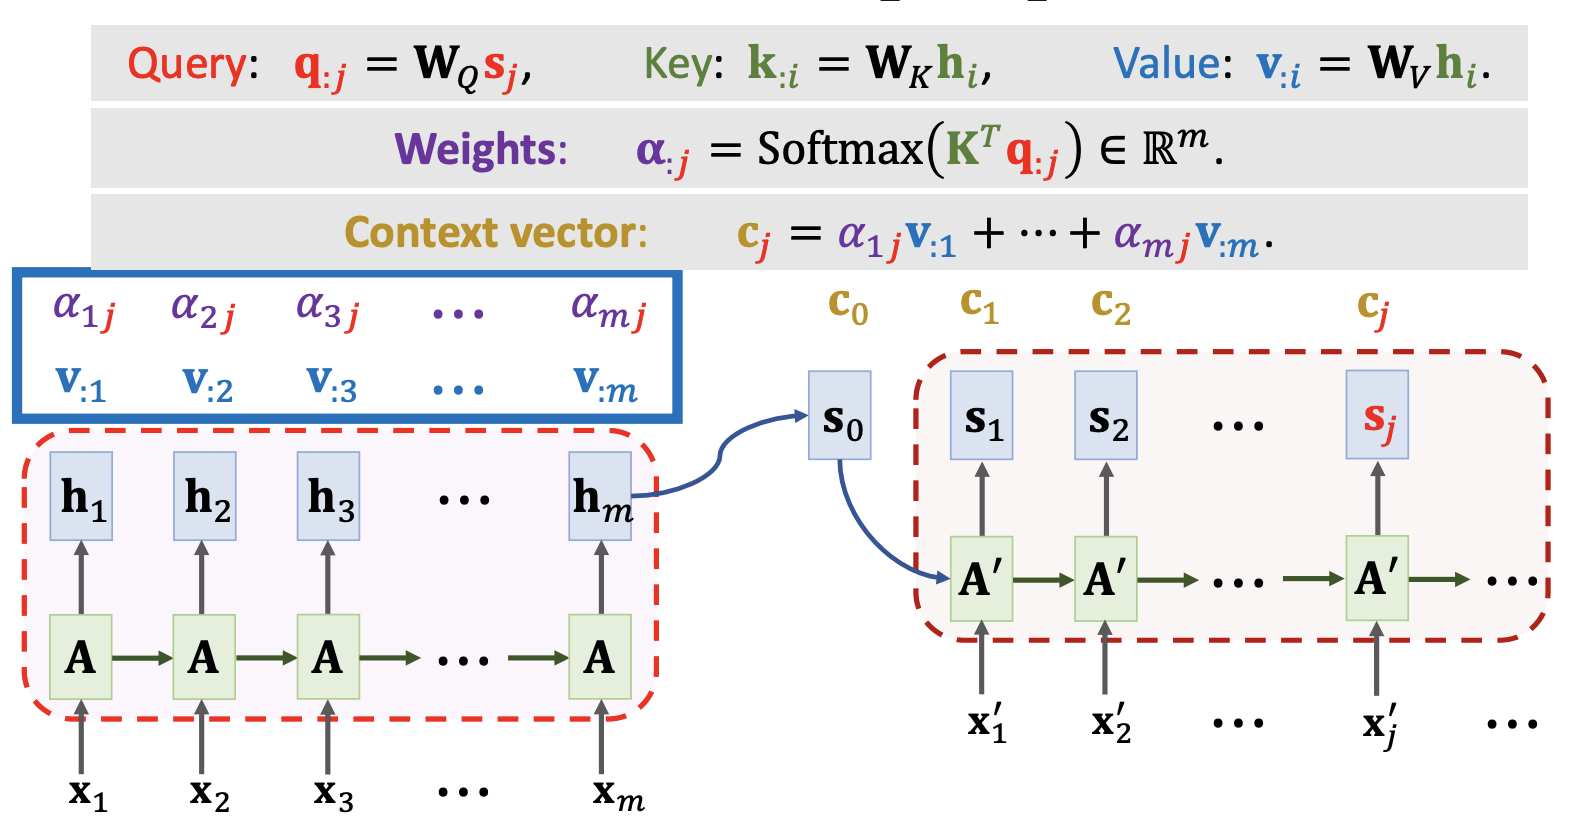

In [291]:
from IPython.display import Image
Image(filename = '/Users/wangzheng/Desktop/01/Deep Learning/NLP/image1.png', width=800, height=400)

## 1. Seq2Seq-Attention
In this chapter, we utilize Seq2Seq-attention model to train a data set of English-Spanish.

In [292]:
# import APIs
from tokenize import TokenInfo
from turtle import pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras
import unicodedata
import re

### 1.1 Data Preprocessing
#### 1.1.1 Remove Useless Charater 

In [293]:
def unicode_to_ascii(s):
    """
    Convert some special letter in spanish from unicode to ascii, in the mean time, filtering the stress mark in Spanish
    """
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(s):
    """
    Seperate the punctuation and letters, as well as remove the remaining blanks
    """
    s = unicode_to_ascii(s.lower().strip())
    # add blank 
    s = re.sub(r"([?.!,¿])", r" \1 ", s)
    # change multiple blanks to a single blank
    s = re.sub(r'[" "]+', " ", s)
    # substitute the character to blank except letters and marks
    s = re.sub(r'[^a-zA-Z?.!¿]', " ", s)
    # remove the blank at the beginning and the end
    s = s.rstrip().strip()
    # add the beginning and end mark
    s = '<start> ' + s + ' <end>'

    return s

def parse_data(filename):
    """
    parse data stored in file
    """
    lines = open(filename, encoding='UTF-8').read().strip().split('\n')
    pairs = [line.split('\t') for line in lines]

    sentence_pairs = [[pair[0], pair[1]] for pair in pairs]
    sentence_pairs = sentence_pairs[:30000]
    # print(sentence_pairs)

    preprocessed_sentence_pair = [
        (preprocess_sentence(en), preprocess_sentence(sp)) 
        for en, sp in sentence_pairs]

    return zip(*preprocessed_sentence_pair)


english, spanish = parse_data("/Users/wangzheng/Desktop/spa.txt")
# print(english[0:100])
# print(spanish[0:100])

#### 1.1.2 Text to Sequence
After preprocessing the given language data set by eliminating the useless characters, it is time to generate the tokenizer of the data set. In other words, converting the texts to sequences, which can be divided into the following steps:
* Step1: Tokenization, which breaks a piece of text down into a list of tokens.
* Step2: Build dictionary, which can map a sentence to a integer sequence.
* Step3: One_Hot Encoding, which may omit some letters or pads the sentence according to the length

In [294]:
def tokenizer(language):
    tokenizer = keras.preprocessing.text.Tokenizer(
        num_words=None, filters='', split=' ')
    
    # step1: generate the dictiories
    tokenizer.fit_on_texts(language)
    # step2: conver the sentences to a sequence
    tensor = tokenizer.texts_to_sequences(language)
    # step3: Padding
    tensor = keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

input_tensor, input_tokenizer = tokenizer(spanish)
output_tensor, output_tokenizer = tokenizer(english)

def max_length(tensor):
    """
    find the max length among all the sequences
    """
    return max(len(t) for t in tensor)

max_length_input = max_length(input_tensor)
max_length_output = max_length(output_tensor)
 
print(max_length_input, max_length_output)

15 10


#### 1.1.3 Generate DataSet

In [295]:
from sklearn.model_selection import train_test_split

input_train, input_evl, output_train, output_evl = train_test_split(
    input_tensor, output_tensor, test_size=0.2
)

print(len(input_train), len(output_evl))

def make_dataset(input_tensor, output_tensor, batch_size, epochs, shuffle):
    """
    generate data set
    """
    dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor))

    if shuffle:
        dataset = dataset.shuffle(30000)

    dataset = dataset.repeat(epochs).batch(
        batch_size, drop_remainder=True)
    
    return dataset

batch_size = 64
epochs = 30

train_dataset = make_dataset(input_train, output_train, batch_size, epochs, True)
eval_dataset = make_dataset(input_evl, output_evl, batch_size, 1, False)

for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x)
    print(y)

24000 6000
(64, 15)
(64, 10)
tf.Tensor(
[[   1    5  156 2367    4    2    0    0    0    0    0    0    0    0
     0]
 [   1  158 3765    3    2    0    0    0    0    0    0    0    0    0
     0]
 [   1   11  397  304    3    2    0    0    0    0    0    0    0    0
     0]
 [   1   76   20  363    3    2    0    0    0    0    0    0    0    0
     0]
 [   1   36  126  478    3    2    0    0    0    0    0    0    0    0
     0]
 [   1    5  591 1032    4    2    0    0    0    0    0    0    0    0
     0]
 [   1   51   11   35   12   74    3    2    0    0    0    0    0    0
     0]
 [   1   31   11  722    9  796    3    2    0    0    0    0    0    0
     0]
 [   1  685    3    2    0    0    0    0    0    0    0    0    0    0
     0]
 [   1 1302  201    3    2    0    0    0    0    0    0    0    0    0
     0]
 [   1   33   16 3993    3    2    0    0    0    0    0    0    0    0
     0]
 [   1   33   28  185    3    2    0    0    0    0    0    0    0    0
     0]


#### 1.1.4 Construct Encoder
Before input the original texts to the neural networks, the sequence should be convert to a vetor, which process is called word embedding. Word embedding process can be achieved by the following steps:
* Step1: represent words using one-hot vectors.
* Step2: map the one-hot vectors to low-dimensional vectors by
                    $$ X_i = W^T e_i$$
                    $$ [d * 1] = [d * v]·[v * 1]$$
where $W$ is parameter matrix which can be learned from training data, and $e_i$ is the one-hot vector of the i-th word in dictionar. In keras, we can use Embedding function to implement by determining the value of d, v and length of each sequence. The above equation can be illustrated as follows:

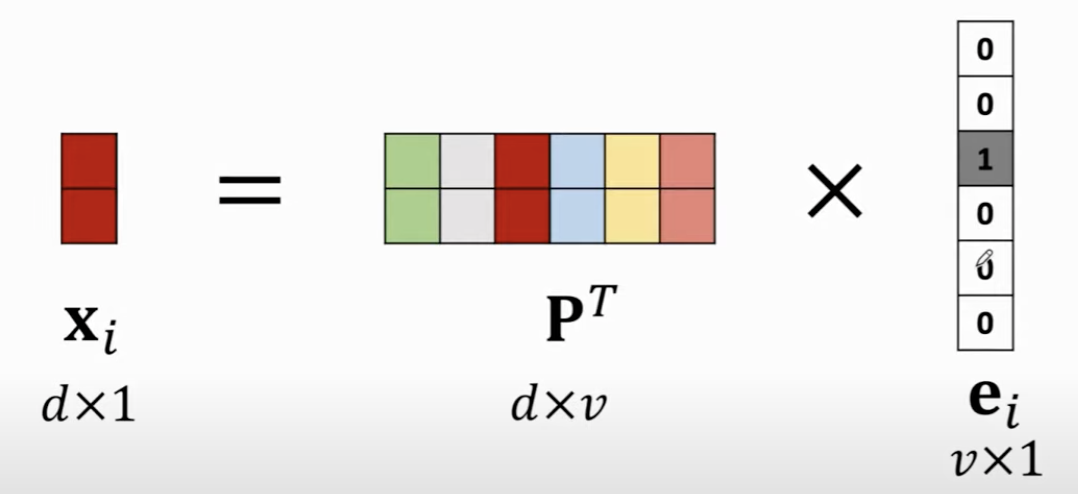

In [296]:
Image(filename = '/Users/wangzheng/Desktop/01/Deep Learning/NLP/image2.png', width=500, height=200)

In [297]:
# embedding dims used to represent the word, i.e., d
embedding_dims = 256
# the number of neural
units = 1024
# value of v
input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

class Encoder(keras.Model):
    """
    encoding the sequence
    """
    def __init__(self, vocab_size, embedding_dims, encoding_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoding_units = encoding_units
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dims)
        self.gru = keras.layers.GRU(self.encoding_units, 
                                    return_sequences = True,
                                    return_state = True,
                                    recurrent_initializer='glorot_uniform')
    
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return x, output, state

    def initial_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoding_units))

encoder = Encoder(input_vocab_size, embedding_dims, units, batch_size)
sample_hidden = encoder.initial_hidden_state()
embedded_sequence, sample_output, sample_hidden = encoder.call(x, sample_hidden)

print(sample_hidden.shape)
print(sample_output.shape)
print(embedded_sequence.shape)


(64, 1024)
(64, 15, 1024)
(64, 15, 256)


#### 1.1.5 Construct Attention
In this part, the Bahdanau Attention scheme is implemetd. Recalling the math expression of this kind of attention:  \
                                            Key: $$K_{:i}=W_k h_i$$
                                           Query: $$q_{:j}=W_Q s_j$$
                                            $$ score =W_V tanh(K_{:i}+q_{:j})$$
                                            $$ \alpha_{:j}=softmax(score) $$


In [298]:
class BahdanauAttention(keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.Wk = keras.layers.Dense(units)
        self.WQ = keras.layers.Dense(units)
        self.Wv = keras.layers.Dense(1)

    def call(self, decoder_hidden, encoder_outputs):
        # decoder_hidden.shape: [batch_size, units]
        # encoder_output.shape: [batch_size, length, units]
        decoder_hidden_with_time_axis = tf.expand_dims(decoder_hidden, 1)

        # before V: [batch_size, length, units]
        # after V: [batch_size, length, 1]
        score = self.Wv(tf.nn.tanh(self.Wk(encoder_outputs) + self.WQ(decoder_hidden_with_time_axis)))

        # shape: [batch_size, length, 1]
        attention_weights = tf.nn.softmax(score, axis = 1)

        # shape: [batch_size, length, units]
        context_vector = attention_weights * encoder_outputs

        # shape: [batch_size, units]
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

#### 1.1.6 Constrcut Decoder

In [299]:
class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_dims, decoding_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decoding_units = decoding_units
        self.embedding = keras.layers.Embedding(
            vocab_size, embedding_dims)
        self.gru = keras.layers.GRU(self.decoding_units,
                                    return_sequences = True,
                                    return_state = True,
                                    recurrent_initializer= 'glorot_uniform')
        self.fc = keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.decoding_units)

    def call(self, x ,hidden, encoding_outputs):
        # context_vector shape: (batch_size, units)
        context_vector, attention_weights = self.attention(hidden, encoding_outputs)

        # before embedding: [batch_size, 1]
        # after embedding: [batch_size, 1, embedding_units]
        x = self.embedding(x)

        combined_x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)

        # output shape: [batch_size, 1, decoding_units]
        # state shape: [batch_size, decoding_units]
        output, state = self.gru(combined_x)

        # output shape: [batch_size, decoding_units]
        output = tf.reshape(output, (-1, output.shape[2]))

        output = self.fc(output)

        return output, state, attention_weights

decoder = Decoder(output_vocab_size, embedding_dims, units, batch_size)

#### 1.1.7 Constrcut Loss Function

In [304]:
def loss_function(real, pred):

    loss_object = keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True, reduction='none') 

    mask = tf.math.logical_not(tf.math.equal(real, 0))

    loss = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss.dtype)

    loss *= mask

    return tf.reduce_mean(loss)

def train_step(input, target, encoding_hidden):
    loss = 0
    optimizer = keras.optimizers.Adam()
    with tf.GradientTape() as tape:
        _, encoding_outputs, encoding_hidden = encoder(input, encoding_hidden)
        decoding_hidden = encoding_hidden

        # eg: <start> I am here <end>
        # 1. <start> --> I
        # 2. I --> am
        # 3. am --> here
        # 4. here --> <end>
        for t in range(0, target.shape[1] - 1):
            decoding_input = tf.expand_dims(target[:, t], 1)
            predictions, decoding_hidden, _ = decoder(decoding_input, 
                                    decoding_hidden, encoding_outputs)

            loss += loss_function(target[:, t+1], predictions)

    batch_loss = loss / int(target.shape[0])
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

#### 1.1.8 Training Process

In [305]:
epochs = 10
steps_per_epoch = len(input_tensor) // batch_size

for epoch in range(epochs):
    start = time.time()
    # initialize the encoding hidden
    encoding_hidden = encoder.initial_hidden_state()

    total_loss = 0

    for (batch, (input, target)) in enumerate(train_dataset.take(steps_per_epoch)):
        batch_loss = train_step(input, target, encoding_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print("Epoch {} Batch {} Loss{:.4f}".format(epoch + 1, batch, batch_loss.numpy()))
    
    print("Epoch {} Loss {:.4f}".format(epoch + 1, total_loss / steps_per_epoch))
    print("Time take for 1 epoch {} sec\n".format(time.time()-start))

Epoch 1 Batch 0 Loss0.5051
Epoch 1 Batch 100 Loss0.3966
Epoch 1 Batch 200 Loss0.3546
Epoch 1 Batch 300 Loss0.3046
Epoch 1 Batch 400 Loss0.2907
Epoch 1 Loss 0.3428
Time take for 1 epoch 823.1483190059662 sec

Epoch 2 Batch 0 Loss0.3026
Epoch 2 Batch 100 Loss0.2703
Epoch 2 Batch 200 Loss0.2694
Epoch 2 Batch 300 Loss0.2641
Epoch 2 Batch 400 Loss0.2698
Epoch 2 Loss 0.2716
Time take for 1 epoch 815.4771411418915 sec

Epoch 3 Batch 0 Loss0.2459
Epoch 3 Batch 100 Loss0.2461
Epoch 3 Batch 200 Loss0.2478
Epoch 3 Batch 300 Loss0.2398
Epoch 3 Batch 400 Loss0.2489
Epoch 3 Loss 0.2434
Time take for 1 epoch 803.5244100093842 sec

Epoch 4 Batch 0 Loss0.2119
Epoch 4 Batch 100 Loss0.2329
Epoch 4 Batch 200 Loss0.2112
Epoch 4 Batch 300 Loss0.2256
Epoch 4 Batch 400 Loss0.2249
Epoch 4 Loss 0.2256
Time take for 1 epoch 806.362685918808 sec

Epoch 5 Batch 0 Loss0.2103
Epoch 5 Batch 100 Loss0.2015
Epoch 5 Batch 200 Loss0.2129
Epoch 5 Batch 300 Loss0.1974
Epoch 5 Batch 400 Loss0.2128
Epoch 5 Loss 0.2124
Time t

#### 1.1.9 Evaluation the model

In [321]:
def evaluate(input_sentence):
    # which is ued to draw the confusion matrix
    attention_matrix = np.zeros((max_length_output, max_length_input))

    # preprocess the sentence 
    input_sequence = preprocess_sentence(input_sentence)
    
    # convert text to sequence
    inputs = [input_tokenizer.word_index[token] for token in input_sequence.split(' ')]

    # padding
    inputs = tf.convert_to_tensor(keras.preprocessing.sequence.pad_sequences(
        [inputs], maxlen=max_length_input, padding = 'post'
    ))

    results = ''
    encoding_hidden = tf.zeros((1, units))

    _, encoding_outputs, encoding_state = encoder(inputs, encoding_hidden)
    decoding_hidden = encoding_hidden

    # eg: <start> -> A
    # A -> B -> C -> D
    decoding_input = tf.expand_dims([output_tokenizer.word_index['start']], 0)

    for t in range(max_length_output):
        prediction, decoding_hidden, attention_weights = decoder(decoding_input, decoding_hidden, encoding_outputs)

        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_matrix[t] = attention_weights.numpy()

        predicted_index = tf.argmax(prediction[0]).numpy()

        results += output_tokenizer.index_word[predicted_index] + ' '

        if output_tokenizer.index_word[predicted_index] == '<end>':
            return results, input_sentence, attention_matrix

        decoding_input = tf.expand_dims([predicted_index], 0)

    
    return results, input_sentence, attention_matrix

In [324]:
def attention_visulizer(attention_matrix, input_sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention_matrix, cmap = 'viridis')

    font_dict = {'fontsize': 14}

    ax.set_xticklabels([' '] + input_sentence, fontdict = font_dict, rotation = 90)
    ax.set_yticklabels([' '] + predicted_sentence, fontdict = font_dict)

    plt.show()

def translate(input_sentence):
    results, input_sentence, attention_matrix = evaluate(input_sentence)

    print("Input sentence is: %s " % (input_sentence))
    print("Predicted translation: %s" % (results))

    attention_matrix = attention_matrix[:len(results.split(' ')),
                                        : len(input_sentence.split(' '))]
    attention_visulizer(attention_matrix, input_sentence.split(' '), results.split(' '))

Input sentence is: Me siento bien hoy. 
Predicted translation: . <end> 


<ipython-input-324-1c32474e177c>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([' '] + input_sentence, fontdict = font_dict, rotation = 90)
<ipython-input-324-1c32474e177c>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([' '] + predicted_sentence, fontdict = font_dict)


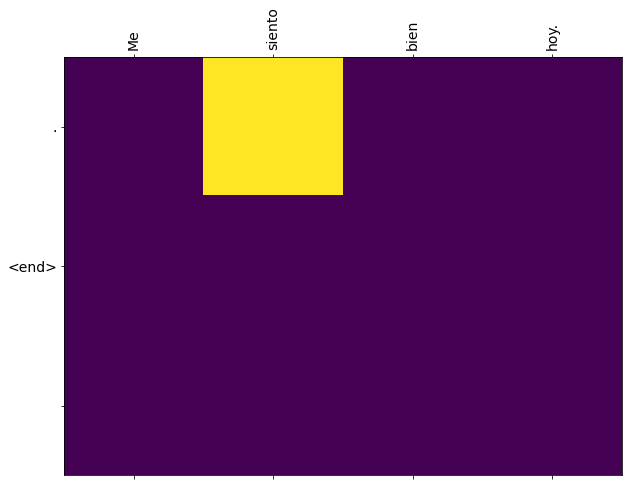

In [325]:
translate("Me siento bien hoy.")